In [1]:
# Import packages and set configuration
from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
# Load tickers
tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "TRXUSDT",
           "DOTUSDT", "LINKUSDT", "SHIBUSDT", "LTCUSDT", "BCHUSDT", "UNIUSDT"]

In [3]:
ps_start = "2024-03-01"
ps_end = "2024-04-01"

trading_start = "2024-03-01"
trading_end = "2024-04-01"

interval = "1h"

In [4]:
# Load data
from modules.data_services.data_pipeline import load_data

df = load_data(
    tickers=tickers,
    start=ps_start,
    end=ps_end,
    interval=interval
)

In [5]:
# Pair Selection
from modules.pair_selection.statistical_tests import johansen_cointegration

joh_df = johansen_cointegration(df)
display(joh_df.head(5))

,pair,trace_stat,crit_95,crit_99,trace_stat - crit_95,trace_stat - crit_99
0,SOLUSDT-ADAUSDT,28.366891,15.4943,19.9349,12.872591,8.431991
1,XRPUSDT-SHIBUSDT,24.592282,15.4943,19.9349,9.097982,4.657382
2,SOLUSDT-DOTUSDT,23.913056,15.4943,19.9349,8.418756,3.978156
3,XRPUSDT-LINKUSDT,22.987367,15.4943,19.9349,7.493067,3.052467
4,DOTUSDT-SHIBUSDT,22.549258,15.4943,19.9349,7.054958,2.614358


In [6]:
fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 1  # always 100% of portfolio

entry_threshold = 2 # 2 std from z-score
exit_threshold = 0
stop_loss = 1.5 #1.5 of an entry threshold; 150%
rolling_window = 100

In [7]:
# Load pair
from modules.data_services.data_pipeline import load_pair
from modules.data_services.data_utils import pre_training_start, add_returns

pt_start = pre_training_start(start=trading_start, interval=interval, rolling_window_steps=rolling_window)

# data = load_pair(x=pairs_2[0].split('-')[0], y=pairs_2[0].split('-')[1], start=pt_start, end=trading_end, interval=interval)
pair = load_pair(x='SOLUSDT', y='ADAUSDT', start=pt_start, end=trading_end, interval=interval)
add_returns(pair) # TODO: UWAGA - UCINA PIERWSZY WIERSZ; BRAĆ START O 1 INTERWAŁ MNIEJSZY

Pair(x='SOLUSDT', y='ADAUSDT', start='2024-02-25', end='2024-04-01', interval='1h', data=                     SOLUSDT  ADAUSDT  SOLUSDT_returns  ADAUSDT_returns  \
open_time                                                                 
2024-02-25 01:00:00   103.78   0.5977         0.000386         0.001173   
2024-02-25 02:00:00   103.32   0.5959        -0.004432        -0.003012   
2024-02-25 03:00:00   103.38   0.5963         0.000581         0.000671   
2024-02-25 04:00:00   103.23   0.5954        -0.001451        -0.001509   
2024-02-25 05:00:00   103.31   0.5949         0.000775        -0.000840   
...                      ...      ...              ...              ...   
2024-03-31 20:00:00   199.43   0.6490        -0.003498         0.002626   
2024-03-31 21:00:00   199.70   0.6461         0.001354        -0.004468   
2024-03-31 22:00:00   200.62   0.6488         0.004607         0.004179   
2024-03-31 23:00:00   202.45   0.6501         0.009122         0.002004   
2024-04-01 

Spread liczymy nie jako różnicę znormalizowanych cen (Gatev et al.), tylko jako resztę z regresji liniowej dzięki której wyciągamy betę, która w momencie otwierania pozycji jest naszym parametrem do określania wag aktywów (beta-hedge).
$$Y_t = \alpha + \beta X_t + \epsilon_t$$

In [8]:
# Run strategy
from modules.performance.strategy import run_strategy

pair.fee_rate = fee_rate
pair.initial_cash = initial_cash

run_strategy(pair, rolling_window, entry_threshold, exit_threshold, stop_loss, position_size, is_spread=False, static_hedge=True, source="prices")
pair.data

,SOLUSDT,ADAUSDT,SOLUSDT_returns,ADAUSDT_returns,SOLUSDT_log_returns,ADAUSDT_log_returns,z_score,alpha,beta,mean,...,q_x,q_y,cash,signal,position,total_pnl,total_fees,net_pnl,total_pnl_pct,net_pnl_pct
open_time,,,,,,,,,,,,,,,,,,,,,
2024-02-29 04:00:00,122.85,0.6567,-0.005424,0.022260,-0.005439,0.022016,1.583064,-37.004504,237.727905,4.278888e-13,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 05:00:00,123.89,0.6665,0.008466,0.014923,0.008430,0.014813,0.953804,-38.647078,240.475255,-1.361400e-13,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 06:00:00,123.45,0.6884,-0.003552,0.032858,-0.003558,0.032330,-1.246434,-35.046835,234.562465,-1.946887e-14,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 07:00:00,125.49,0.6836,0.016525,-0.006973,0.016390,-0.006997,0.079132,-34.899739,234.349257,2.614797e-14,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 08:00:00,131.65,0.6968,0.049088,0.019310,0.047921,0.019125,1.197281,-37.360396,238.430343,-1.145395e-13,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 20:00:00,199.43,0.6490,-0.003498,0.002626,-0.003504,0.002623,1.719897,33.225419,242.503531,-3.433342e-13,...,-1.576676,151637.909503,-1.455192e-11,0.0,-1.0,27022.079110,1754.426212,25267.652897,0.270221,0.252677
2024-03-31 21:00:00,199.70,0.6461,0.001354,-0.004468,0.001353,-0.004478,1.836437,52.911009,212.431224,-1.514877e-13,...,-1.576676,151637.909503,-1.455192e-11,0.0,-1.0,27461.403345,1754.426212,25706.977132,0.274614,0.257070
2024-03-31 22:00:00,200.62,0.6488,0.004607,0.004179,0.004596,0.004170,1.847479,77.400440,174.999438,7.327117e-13,...,-1.576676,151637.909503,-1.455192e-11,0.0,-1.0,27050.530447,1754.426212,25296.104234,0.270505,0.252961


In [9]:
# Calculate statistics
from modules.performance.strategy import calculate_stats

pair.stats = calculate_stats(pair)
pair.stats

,0% fee,0.05% fee
metric,,
total_return,0.2685,0.2505
cagr,14.2334,11.9291
volatility,0.0074,0.0074
volatility_annual,0.6898,0.6927
max_drawdown,-0.0901,-0.0922
win_count,10.0000,10.0000
lose_count,8.0000,8.0000
win_rate,0.5556,0.5556
max_win,0.1723,0.1719


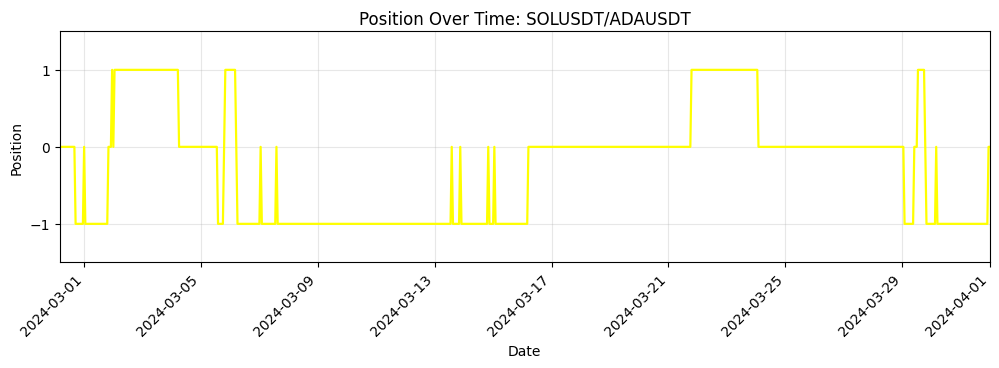

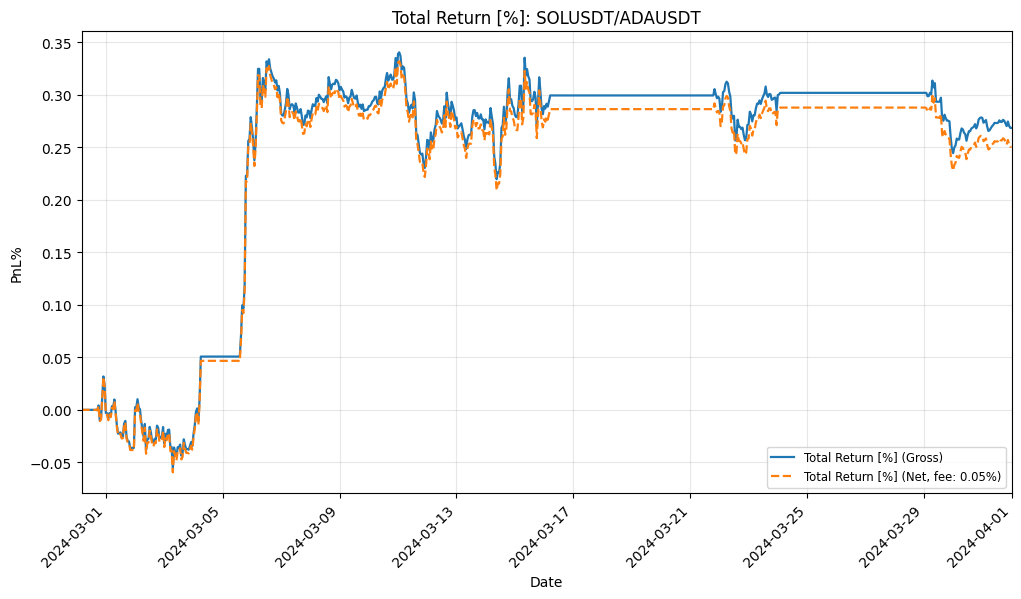

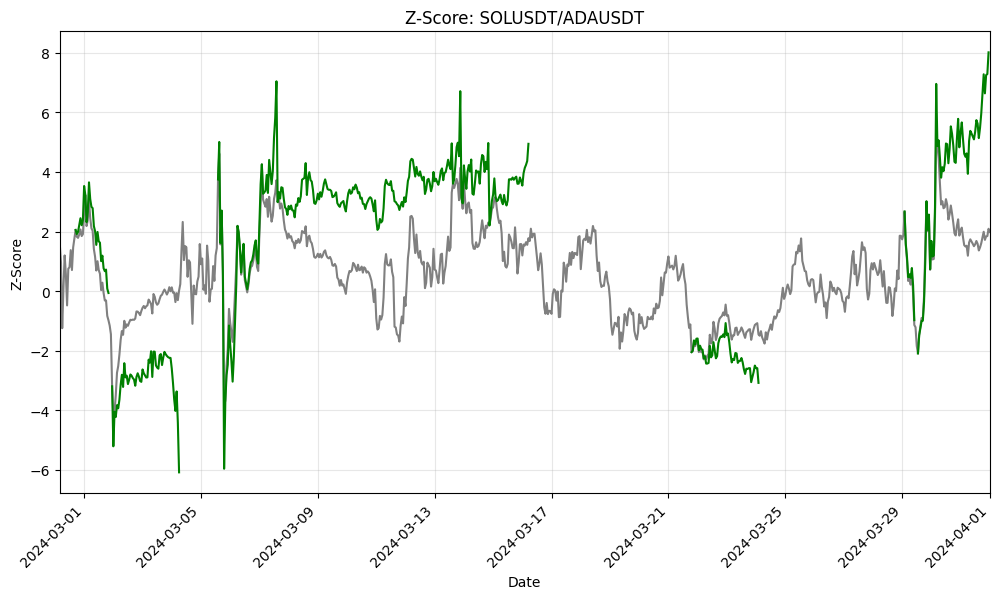

In [10]:
# Visualization
from modules.visualization.plots import plot_pnl, plot_positions, plot_zscore

plot_positions(pair, 'strategy', False, True)
plot_pnl(pair, 'strategy', False, True)
plot_zscore(pair)